<h1>Simple Power Analysis (SPA)</h1>

This Notebook will introduce you to analyzing the behavior of devices by identifying when they perform specific operations. We will focus on a **simple password check** and demonstrate how to conduct a basic power analysis on a target device.

Adapted from lab 9 of the [Hardware Hacking Handbook Notebooks](https://github.com/HardwareHackingHandbook/notebooks)

**Reference** - The Hardware Hacking Handbook: Breaking Embedded Security with Hardware Attacks by Jasper van Woudenberg and Colin O'Flynn.



## Initial Setup

Run the Below code-block **ONLY** once and then restart your runtime. After restarting runtime, download the other two files from the drive link, and upload them on this google colab notebook. Now you are good to go! Move forward and run the following codes.



In [ ]:
pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.3 MB/s eta 0:00:00


# Password-cracking using SPA

The below code block is only to enable google collab to use interactive ploting tools.

(PS - nothing related to password carcking)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


### Power Trace Gathering

Instead of a physical setup involving target devices and an oscilloscope for capturing power traces, we will simulate power analysis for password cracking by using a pre-existing dataset ('lab2_1b_passwords_full.p'). This approach allows us to bypass the immediate need for hardware and focus on the analysis techniques for extracting the password from simulated power consumption data. We will be proceeding as if we had obtained power traces from a target device during password attempts and will now apply simple power analysis (SPA) to identify the correct password.


In [ ]:
import pickle
import random
import time

#load simulation data
traces_to_load = pickle.load(open(r"lab2_1b_passwords_full.p", "rb"))

#function for capturing power traces
def cap_pass_trace(pass_guess):
    known_passwd = "h0px3"
    trylist = "abcdefghijklmnopqrstuvwxyz0123456789 \x00" #set of valid characters in the password

    if len(pass_guess) > 5:
        raise ValueError("Only guesses up to 5 chars recorded, sorry about that.")

    for a in pass_guess:
        if a not in trylist:
            raise ValueError("Part of guess (%c) not in recorded enumeration list (%s)" % (a, trylist))

    # Only recorded is correct passwords
    recorded_pw = ""
    for i in range(len(pass_guess)):
        if known_passwd[i] == pass_guess[i]:
          recorded_pw += pass_guess[i]
        else:
          recorded_pw += " "

    time.sleep(0.05)

    return traces_to_load[recorded_pw][random.randint(0, 99)]

trace_test = cap_pass_trace("h")

# Basic sanity check
assert len(trace_test) == 3000
print("✔ OK to continue (SIMULATED)!")


✔ OK to continue (SIMULATED)!


## Exploration of the capturing power trace function

Once you have understood the working if the cap_pass_trace function from the above code block. You can see the working of the function in the below code block.

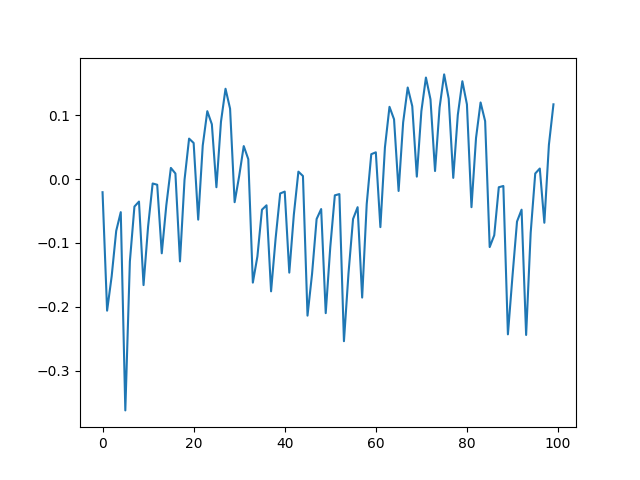

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.figure()

plt.plot(cap_pass_trace("7")[0:100])

plt.show()

## Automating an Attack against a Single Character

So what can we do with these power traces? First off - let us cheat a bit, and use the fact that we know that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can we do with this? Let's compare the power trace obtained if we send `h` as the the first character with the power trace obtained if we send any other guess for the first digit.


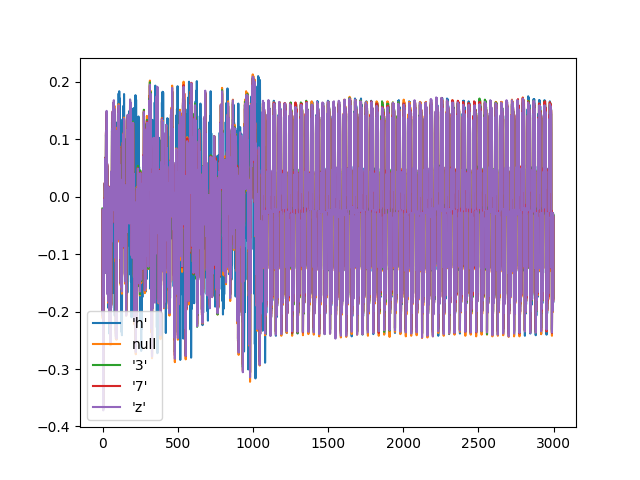

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cap_pass_trace("h"), label="'h'")
plt.plot(cap_pass_trace("\x00"), label="null")
plt.plot(cap_pass_trace("3"), label="'3'")
plt.plot(cap_pass_trace("7"), label="'7'")
plt.plot(cap_pass_trace("x"), label="'z'")


plt.legend()
plt.show()


We can see that the power traces for the wrong first characters, all follow the same path, and the trace for the correct character is an "outlier".

<!-- Now this fact can be used to find the first character of our password by just plotting the power traces of all possible choices of the first character and identifying the outlier. -->


Let's automate the attack against the **first** character of the password. Since we wouldn't know the password in a real scenario, we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password.

Let us plot the trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password, which means that every other wrong character's power trace will follow this trace closely while the correct character's trace will stray away from it. We will use this null character trace as a reference and plot the difference between this known reference & every other capture.



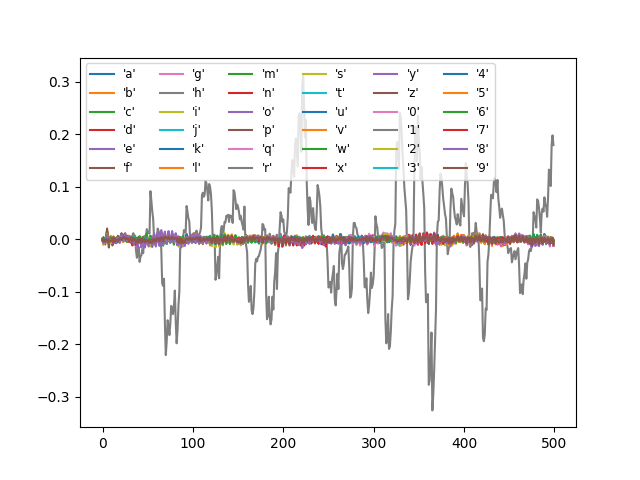

In [ ]:
%matplotlib widget
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("\x00")[0:500]

for c in 'abcdefghijklmnopqrstuvwxyz0123456789':
    trace = cap_pass_trace(c)[0:500]
    plt.plot(trace - ref_trace, label=f"'{c}'")
plt.legend(ncol=6, fontsize='small')



Extending the same logic as used above - we modify the code to capture the trace of a correct first character + every other wrong second character.

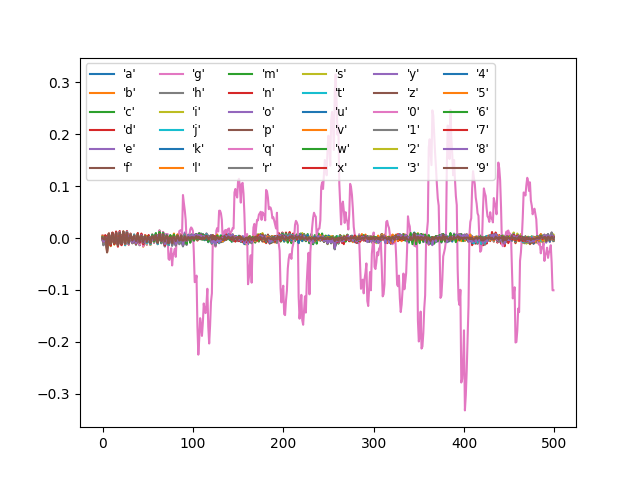

In [ ]:
%matplotlib widget
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("h\x00")[0:500]

for c in 'abcdefghijklmnopqrstuvwxyz0123456789':
    trace = cap_pass_trace('h' + c)[0:500]
    plt.plot(trace - ref_trace, label=f"'{c}'")
plt.legend(ncol=6, fontsize='small')
plt.show()

# Finding the outlier trace

How do we find which input gives the outlier trace? One obvious thing we could do is analyze the graphs above and see which trace has the highest deviation from the reference?
But what if we could automate this process too and also make it more reliable?

For this we can make use of some handy functions: `np.sum()` and `np.abs()`.

Using the first one will get absolute values:

```python
import numpy as np
np.abs([-1, -3, 1, -5, 6])

    Out[]: array([1, 3, 1, 5, 6])
```

The second one will add up all the numbers.

```python
import numpy as np    
np.sum([-1, -3, 1, -5, 6])

    Out[]: -2
```

Using just `np.sum()` means positive and negative differences will cancel each other out - so we instead use `np.sum(np.abs(DIFF))` to get a good number indicating how "close" the match was.


In [ ]:
import numpy as np
ref_trace = cap_pass_trace( "\x00")

for c in 'abcdefghijklmnopqrstuvwxyz0123456789':
    trace = cap_pass_trace(c)
    diff = np.sum(np.abs(trace - ref_trace))

    print("{:1} diff = {:2}".format(c, diff))

a diff = 6.1826171875
b diff = 7.189453125
c diff = 7.3876953125
d diff = 9.4462890625
e diff = 7.3828125
f diff = 9.7568359375
g diff = 8.708984375
h diff = 98.6240234375
i diff = 7.26953125
j diff = 6.541015625
k diff = 10.017578125
l diff = 9.744140625
m diff = 8.708984375
n diff = 7.439453125
o diff = 7.3828125
p diff = 0.0
q diff = 7.26953125
r diff = 7.0859375
s diff = 6.5771484375
t diff = 6.640625
u diff = 8.8779296875
v diff = 6.7900390625
w diff = 6.0859375
x diff = 8.375
y diff = 10.3095703125
z diff = 7.3076171875
0 diff = 6.4580078125
1 diff = 10.080078125
2 diff = 8.3984375
3 diff = 6.0537109375
4 diff = 0.0
5 diff = 11.005859375
6 diff = 7.455078125
7 diff = 8.0791015625
8 diff = 7.841796875
9 diff = 7.3779296875


The input with the higest value of diff is the outlier! Observing the values obtained, we can set a threshold value to be, say, 50 and the character which has the value of diff greater than this threshold is our desired character!

---



## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we will attack each character in sequence. We will combine all the logic we have used above and loop through 4 times (as we have a four digit password), and just build up the password based on brute-forcing each character.



In [ ]:
guessed_pw = ""


for i in range(0, 5):

    ref_trace = cap_pass_trace(guessed_pw + "\x00")

    for c in 'abcdefghijklmnopqrstuvwxyz0123456789':
        trace = cap_pass_trace(guessed_pw + c)
        diff = np.sum(np.abs(trace - ref_trace))

        if diff > 40.0:
            guessed_pw += c
            print(guessed_pw)
            break

h
h0
h0p
h0px
h0px3


We should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!
